# Importing Required Libraries

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import parse
import multiprocessing
from bs4 import BeautifulSoup # Text Cleaning
import re, string # Regular Expressions, String
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords # stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer # for word stemming
from nltk.stem import WordNetLemmatizer # for word lemmatization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from pad_sequences import pad_sequences_multi
import unicodedata
import html
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Creating a function to get all the app names

In [3]:
path = r'./data'
def getAppNames(path):
    list_of_files = os.listdir(path)
    app_names = []
    for file in list_of_files:
        name = parse.parse('submission_{}.csv',file)
        app_names.append(str(name)[10:-7])
    
    return app_names

appNames = getAppNames(path)
appNames

['candidate', 'jobget', 'jobseeker', 'jobswipe', 'mobile']

##### To create the final_submission.csv file, building a data pipeline function that takes path and app names as input and returns the final dataframe.

In [4]:
def creating_df(path, appNames):
    dfs = []
    for file in os.listdir(path):
        print("Reading "+file)
        data = pd.read_csv(path+'/'+ file)
        df = pd.DataFrame(data)
        print("Current Data Frame shape ")
        print(df.shape)
        df['appName'] = appNames[os.listdir(path).index(file)]
        dfs.append(df)
    print("Total Files found: ", len(dfs))
    final_df = pd.DataFrame()
    for i in range(len(dfs)):
        final_df = pd.concat([final_df, dfs[i]], axis=0)
        
    return final_df
    
final_df = creating_df(path, appNames)
final_df

Reading submission_candidate.csv
Current Data Frame shape 
(143, 10)
Reading submission_jobget.csv
Current Data Frame shape 
(3382, 10)
Reading submission_jobseeker.csv
Current Data Frame shape 
(8909, 10)
Reading submission_jobswipe.csv
Current Data Frame shape 
(697, 10)
Reading submission_mobile.csv
Current Data Frame shape 
(105, 10)
Total Files found:  5


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appName
0,d505016e-3b37-4ba2-97cf-16c9ef54f84c,David Webster,https://play-lh.googleusercontent.com/a-/ACB-R...,Found great bar jobs on here in the past but n...,1,0,3.2.11,2023-02-08 19:41:20,NaN,NaN,candidate
1,eae5efd4-26eb-469d-b793-f9689510ebbf,Joshua Espinoza,https://play-lh.googleusercontent.com/a/AGNmyx...,Try to upload resume and it just stays uploading!,2,0,3.2.6,2022-09-26 04:18:21,NaN,NaN,candidate
2,c7156674-d0bf-497e-924e-07802e9cda9d,Robert Basom,https://play-lh.googleusercontent.com/a-/ACB-R...,"This is one of the worst apps I've ever used,w...",1,0,NaN,2022-07-20 08:11:02,NaN,NaN,candidate
3,520a4e2f-d352-4fe4-a63b-ceea058663bf,Daniel DLS,https://play-lh.googleusercontent.com/a-/ACB-R...,If I cant upload a resume because for whatever...,1,1,3.2.5,2022-06-27 23:48:52,NaN,NaN,candidate
4,254d1260-7a30-4ae1-8c68-53f597c3c84c,Morris Kagunya,https://play-lh.googleusercontent.com/a-/ACB-R...,It's not logging in,1,0,3.2.3,2022-05-16 22:59:26,NaN,NaN,candidate
...,...,...,...,...,...,...,...,...,...,...,...
100,45d71edd-c573-4bc2-a219-ac7e31cb90ad,Alan J,https://play-lh.googleusercontent.com/a-/ACB-R...,Rather tasty,5,7,1.0.1.364,2021-11-14 16:15:49,NaN,NaN,mobile
101,6d98a697-0814-46f1-b8b8-fbbcb3f9f3b3,Tracy Nguyen,https://play-lh.googleusercontent.com/a-/ACB-R...,I am about to do it myself to make it happen a...,5,9,NaN,2021-11-13 03:00:17,NaN,NaN,mobile
102,8bbd9f45-73b4-42e0-8057-d4fc362c121a,Jeremy Yatchmenoff,https://play-lh.googleusercontent.com/a/AGNmyx...,The best,5,5,1.0.1.364,2021-11-03 15:02:20,NaN,NaN,mobile
103,6a62c0a3-c52d-4900-9fd4-32a10c277afe,David Shaw,https://play-lh.googleusercontent.com/a-/ACB-R...,Nice app,5,8,1.0.1.364,2021-10-22 06:44:09,NaN,NaN,mobile


In [5]:
final_df.to_csv(path+'/'+'final_submission.csv', index=False) 
print("Final Submission File SAVED!")
print("Final File Shape: ", final_df.shape)
final_df.head()

Final Submission File SAVED!
Final File Shape:  (13236, 11)


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appName
0,d505016e-3b37-4ba2-97cf-16c9ef54f84c,David Webster,https://play-lh.googleusercontent.com/a-/ACB-R...,Found great bar jobs on here in the past but n...,1,0,3.2.11,2023-02-08 19:41:20,NaN,NaN,candidate
1,eae5efd4-26eb-469d-b793-f9689510ebbf,Joshua Espinoza,https://play-lh.googleusercontent.com/a/AGNmyx...,Try to upload resume and it just stays uploading!,2,0,3.2.6,2022-09-26 04:18:21,NaN,NaN,candidate
2,c7156674-d0bf-497e-924e-07802e9cda9d,Robert Basom,https://play-lh.googleusercontent.com/a-/ACB-R...,"This is one of the worst apps I've ever used,w...",1,0,NaN,2022-07-20 08:11:02,NaN,NaN,candidate
3,520a4e2f-d352-4fe4-a63b-ceea058663bf,Daniel DLS,https://play-lh.googleusercontent.com/a-/ACB-R...,If I cant upload a resume because for whatever...,1,1,3.2.5,2022-06-27 23:48:52,NaN,NaN,candidate
4,254d1260-7a30-4ae1-8c68-53f597c3c84c,Morris Kagunya,https://play-lh.googleusercontent.com/a-/ACB-R...,It's not logging in,1,0,3.2.3,2022-05-16 22:59:26,NaN,NaN,candidate


In [6]:
#creating a nested condition to insert values according to the rating
# if score equal to 3 then neutral
# if score greater than 3 then positive
# if score less than 3 then negative
final_df['sentiment'] = np.where(final_df['score'] == 3, 'neutral', np.where(final_df['score'] <3, 'negative', np.where(final_df['score'] >3, 'positive', np.nan)))
final_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appName,sentiment
0,d505016e-3b37-4ba2-97cf-16c9ef54f84c,David Webster,https://play-lh.googleusercontent.com/a-/ACB-R...,Found great bar jobs on here in the past but n...,1,0,3.2.11,2023-02-08 19:41:20,NaN,NaN,candidate,negative
1,eae5efd4-26eb-469d-b793-f9689510ebbf,Joshua Espinoza,https://play-lh.googleusercontent.com/a/AGNmyx...,Try to upload resume and it just stays uploading!,2,0,3.2.6,2022-09-26 04:18:21,NaN,NaN,candidate,negative
2,c7156674-d0bf-497e-924e-07802e9cda9d,Robert Basom,https://play-lh.googleusercontent.com/a-/ACB-R...,"This is one of the worst apps I've ever used,w...",1,0,NaN,2022-07-20 08:11:02,NaN,NaN,candidate,negative
3,520a4e2f-d352-4fe4-a63b-ceea058663bf,Daniel DLS,https://play-lh.googleusercontent.com/a-/ACB-R...,If I cant upload a resume because for whatever...,1,1,3.2.5,2022-06-27 23:48:52,NaN,NaN,candidate,negative
4,254d1260-7a30-4ae1-8c68-53f597c3c84c,Morris Kagunya,https://play-lh.googleusercontent.com/a-/ACB-R...,It's not logging in,1,0,3.2.3,2022-05-16 22:59:26,NaN,NaN,candidate,negative
...,...,...,...,...,...,...,...,...,...,...,...,...
100,45d71edd-c573-4bc2-a219-ac7e31cb90ad,Alan J,https://play-lh.googleusercontent.com/a-/ACB-R...,Rather tasty,5,7,1.0.1.364,2021-11-14 16:15:49,NaN,NaN,mobile,positive
101,6d98a697-0814-46f1-b8b8-fbbcb3f9f3b3,Tracy Nguyen,https://play-lh.googleusercontent.com/a-/ACB-R...,I am about to do it myself to make it happen a...,5,9,NaN,2021-11-13 03:00:17,NaN,NaN,mobile,positive
102,8bbd9f45-73b4-42e0-8057-d4fc362c121a,Jeremy Yatchmenoff,https://play-lh.googleusercontent.com/a/AGNmyx...,The best,5,5,1.0.1.364,2021-11-03 15:02:20,NaN,NaN,mobile,positive
103,6a62c0a3-c52d-4900-9fd4-32a10c277afe,David Shaw,https://play-lh.googleusercontent.com/a-/ACB-R...,Nice app,5,8,1.0.1.364,2021-10-22 06:44:09,NaN,NaN,mobile,positive


In [7]:
#Checking if any row has null values
final_df['sentiment'].isnull().values.sum() 

0

# Data Preprocessing

In [8]:
# Creating a cleaning function

# set of stopwords to be removed from text
stop = set(stopwords.words('english'))

# update stopwords to have punctuation too
stop.update(list(string.punctuation))

def clean_text(text):
    
    # Remove unwanted html characters
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
    'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
    '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
    ' @-@ ', '-').replace('\\', ' \\ ')
    text = re1.sub(' ', html.unescape(x1))
    
    # remove non-ascii characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    #     # strip html
    #     soup = BeautifulSoup(text, 'html.parser')
    #     text = soup.get_text()
    
    # remove between square brackets
    text = re.sub('\[[^]]*\]', '', text)
    
    # remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # remove twitter tags
    text = text.replace("@", "")
    
    # remove hashtags
    text = text.replace("#", "")
    
    # remove all non-alphabetic characters
    text = re.sub(r'[^a-zA-Z ]', '', text)
    
    # remove stopwords from text
    final_text = []
    for word in text.split():
        if word.strip().lower() not in stop:
            final_text.append(word.strip().lower())
    
    text = " ".join(final_text)
    
    # lemmatize words
    lemmatizer = WordNetLemmatizer()    
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    text = " ".join([lemmatizer.lemmatize(word, pos = 'v') for word in text.split()])
    
    # replace all numbers with "num"
    text = re.sub("\d", "num", text)
    
    return text.lower()

In [9]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13236 entries, 0 to 104
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              13236 non-null  object
 1   userName              13236 non-null  object
 2   userImage             13236 non-null  object
 3   content               13227 non-null  object
 4   score                 13236 non-null  int64 
 5   thumbsUpCount         13236 non-null  int64 
 6   reviewCreatedVersion  10501 non-null  object
 7   at                    13236 non-null  object
 8   replyContent          3396 non-null   object
 9   repliedAt             3396 non-null   object
 10  appName               13236 non-null  object
 11  sentiment             13236 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.3+ MB


In [10]:
final_df = final_df[final_df['content'].notna()]
final_df.shape

(13227, 12)

In [11]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13227 entries, 0 to 104
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              13227 non-null  object
 1   userName              13227 non-null  object
 2   userImage             13227 non-null  object
 3   content               13227 non-null  object
 4   score                 13227 non-null  int64 
 5   thumbsUpCount         13227 non-null  int64 
 6   reviewCreatedVersion  10495 non-null  object
 7   at                    13227 non-null  object
 8   replyContent          3395 non-null   object
 9   repliedAt             3395 non-null   object
 10  appName               13227 non-null  object
 11  sentiment             13227 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.3+ MB


In [12]:
final_df = final_df.drop(['reviewCreatedVersion', 'replyContent', 'repliedAt'], axis=1)

In [13]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13227 entries, 0 to 104
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   reviewId       13227 non-null  object
 1   userName       13227 non-null  object
 2   userImage      13227 non-null  object
 3   content        13227 non-null  object
 4   score          13227 non-null  int64 
 5   thumbsUpCount  13227 non-null  int64 
 6   at             13227 non-null  object
 7   appName        13227 non-null  object
 8   sentiment      13227 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.0+ MB


In [14]:
clean_df = final_df.copy()
clean_df['content'] = final_df['content'].apply(clean_text)

In [15]:
from keybert import KeyBERT

In [16]:
keyModel = KeyBERT()

In [17]:
clean_high_rated_df = pd.concat([clean_df[clean_df['score'] == 4], clean_df[clean_df['score'] == 5]], axis=0)
clean_high_rated_df

,reviewId,userName,userImage,content,score,thumbsUpCount,at,appName,sentiment
6,098e9eef-cd64-41d4-b9e4-a46fc1356dda,Kadar Harris,https://play-lh.googleusercontent.com/a/AGNmyx...,great,4,0,2022-03-25 23:27:33,candidate,positive
31,0b3d424c-edd3-4d76-bce1-d3238ed7d35d,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,ok,4,0,2020-01-31 22:57:34,candidate,positive
32,a2f921b2-049e-4e4a-afff-d44a0ead6cee,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,great app think need update google cause googl...,4,0,2019-11-07 03:53:56,candidate,positive
56,1ca21a55-95af-45b5-a823-9f55fb86426c,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,glitchy profile update annoy position choose l...,4,0,2019-09-17 21:29:28,candidate,positive
59,dccb8488-14bc-4af7-b3df-59efd4df8752,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,excellen app,4,0,2019-08-08 19:40:28,candidate,positive
...,...,...,...,...,...,...,...,...,...
100,45d71edd-c573-4bc2-a219-ac7e31cb90ad,Alan J,https://play-lh.googleusercontent.com/a-/ACB-R...,rather tasty,5,7,2021-11-14 16:15:49,mobile,positive
101,6d98a697-0814-46f1-b8b8-fbbcb3f9f3b3,Tracy Nguyen,https://play-lh.googleusercontent.com/a-/ACB-R...,make happen sake course work together make sur...,5,9,2021-11-13 03:00:17,mobile,positive
102,8bbd9f45-73b4-42e0-8057-d4fc362c121a,Jeremy Yatchmenoff,https://play-lh.googleusercontent.com/a/AGNmyx...,best,5,5,2021-11-03 15:02:20,mobile,positive
103,6a62c0a3-c52d-4900-9fd4-32a10c277afe,David Shaw,https://play-lh.googleusercontent.com/a-/ACB-R...,nice app,5,8,2021-10-22 06:44:09,mobile,positive


In [18]:
doc = ''
for comnt in clean_high_rated_df['content']:
    doc += comnt+'. '
doc

'great. ok. great app think need update google cause google cant find place work work experience recognize app wont let send application job application app basically useless. glitchy profile update annoy position choose list thousand cant enter end date job unless use website also enter job sometimes address show name business great apply though. excellen app. find job fine guy need fix bug cant set interview app doesnt work correctly. bug fix great one best apps hospitality work wish job queen ny would start use app. nice app. good. great big city answer hubdreds list first week schedule dozen interview first month. wish could still view ad apply. great. great far. beautiful app guess still develop doesnt message capability available full site absolutely love site app. awaand x x thes za costcos dead. think app much better actually earn money. easy use. help find many job would never think area good pay. app really good find good job. far would say one thorough helpful job search app

In [19]:
three_word_KW = keyModel.extract_keywords(doc, keyphrase_ngram_range=(1,3), stop_words=None)
print(three_word_KW)

[('job apps good', 0.6892), ('suggest app jobemployment', 0.679), ('job apps great', 0.6783), ('better job apps', 0.6751), ('job app better', 0.6736)]


In [20]:
five_word_KW = keyModel.extract_keywords(doc, keyphrase_ngram_range=(1,5), stop_words=None)
print(five_word_KW)

[('find job good great app', 0.7417), ('find job need excellent app', 0.7411), ('good app opportunity get job', 0.736), ('get excellent app find job', 0.7359), ('good app find job good', 0.7344)]


In [21]:
KW_using_mmr = keyModel.extract_keywords(doc, keyphrase_ngram_range=(1,1), stop_words='english', use_mmr=True, diversity=0.7)
print(KW_using_mmr)

[('jobsearching', 0.4677), ('applay', 0.2156), ('opinion', 0.1018), ('integrate', 0.0882), ('coronavirus', 0.0126)]


In [22]:
KW_using_maxsum = keyModel.extract_keywords(doc, keyphrase_ngram_range=(1,1), stop_words='english', use_maxsum=True, nr_candidates=20, top_n=5)
print(KW_using_maxsum)

[('jobswip', 0.3889), ('appsuper', 0.3985), ('jobemployment', 0.4102), ('jobsearch', 0.4394), ('apps', 0.4427)]


# Classifying reviews with positive and negative experiences 

In [63]:
df = pd.read_csv('./data/final_submission.csv')
df['sentiment'] = np.where(df['score'] > 2.5, 1, 0)
df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appName,sentiment
0,d505016e-3b37-4ba2-97cf-16c9ef54f84c,David Webster,https://play-lh.googleusercontent.com/a-/ACB-R...,Found great bar jobs on here in the past but n...,1,0,3.2.11,2023-02-08 19:41:20,NaN,NaN,candidate,0
1,eae5efd4-26eb-469d-b793-f9689510ebbf,Joshua Espinoza,https://play-lh.googleusercontent.com/a/AGNmyx...,Try to upload resume and it just stays uploading!,2,0,3.2.6,2022-09-26 04:18:21,NaN,NaN,candidate,0
2,c7156674-d0bf-497e-924e-07802e9cda9d,Robert Basom,https://play-lh.googleusercontent.com/a-/ACB-R...,"This is one of the worst apps I've ever used,w...",1,0,NaN,2022-07-20 08:11:02,NaN,NaN,candidate,0
3,520a4e2f-d352-4fe4-a63b-ceea058663bf,Daniel DLS,https://play-lh.googleusercontent.com/a-/ACB-R...,If I cant upload a resume because for whatever...,1,1,3.2.5,2022-06-27 23:48:52,NaN,NaN,candidate,0
4,254d1260-7a30-4ae1-8c68-53f597c3c84c,Morris Kagunya,https://play-lh.googleusercontent.com/a-/ACB-R...,It's not logging in,1,0,3.2.3,2022-05-16 22:59:26,NaN,NaN,candidate,0
...,...,...,...,...,...,...,...,...,...,...,...,...
13231,45d71edd-c573-4bc2-a219-ac7e31cb90ad,Alan J,https://play-lh.googleusercontent.com/a-/ACB-R...,Rather tasty,5,7,1.0.1.364,2021-11-14 16:15:49,NaN,NaN,mobile,1
13232,6d98a697-0814-46f1-b8b8-fbbcb3f9f3b3,Tracy Nguyen,https://play-lh.googleusercontent.com/a-/ACB-R...,I am about to do it myself to make it happen a...,5,9,NaN,2021-11-13 03:00:17,NaN,NaN,mobile,1
13233,8bbd9f45-73b4-42e0-8057-d4fc362c121a,Jeremy Yatchmenoff,https://play-lh.googleusercontent.com/a/AGNmyx...,The best,5,5,1.0.1.364,2021-11-03 15:02:20,NaN,NaN,mobile,1
13234,6a62c0a3-c52d-4900-9fd4-32a10c277afe,David Shaw,https://play-lh.googleusercontent.com/a-/ACB-R...,Nice app,5,8,1.0.1.364,2021-10-22 06:44:09,NaN,NaN,mobile,1


In [75]:
df = df[df['content'].notna()]
df.shape

(13227, 12)

In [76]:
df.content[10000]

'Easy to use, great job locater.'

In [77]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [78]:
sia.polarity_scores(df.content[10000])

{'neg': 0.0, 'neu': 0.364, 'pos': 0.636, 'compound': 0.7906}

In [79]:
sia.polarity_scores(df.content[0])

{'neg': 0.159, 'neu': 0.775, 'pos': 0.066, 'compound': -0.5572}

In [82]:
df = df.reset_index()

In [97]:
# Running the polarity score throughout the dataframe
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['content']
    myid = i
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/13227 [00:00<?, ?it/s]

In [98]:
vaders = pd.DataFrame(res).T
vaders

,neg,neu,pos,compound
0,0.159,0.775,0.066,-0.5572
1,0.000,1.000,0.000,0.0000
2,0.177,0.823,0.000,-0.6249
3,0.134,0.866,0.000,-0.7546
4,0.000,1.000,0.000,0.0000
...,...,...,...,...
13222,0.000,1.000,0.000,0.0000
13223,0.039,0.854,0.107,0.7650
13224,0.000,0.192,0.808,0.6369
13225,0.000,0.263,0.737,0.4215


In [100]:
vaders = pd.DataFrame(res).T
vaders = pd.concat([vaders, df], axis=1)

In [101]:
vaders.head()

,neg,neu,pos,compound,index,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appName,sentiment
0,0.159,0.775,0.066,-0.5572,0,d505016e-3b37-4ba2-97cf-16c9ef54f84c,David Webster,https://play-lh.googleusercontent.com/a-/ACB-R...,Found great bar jobs on here in the past but n...,1,0,3.2.11,2023-02-08 19:41:20,NaN,NaN,candidate,0
1,0.000,1.000,0.000,0.0000,1,eae5efd4-26eb-469d-b793-f9689510ebbf,Joshua Espinoza,https://play-lh.googleusercontent.com/a/AGNmyx...,Try to upload resume and it just stays uploading!,2,0,3.2.6,2022-09-26 04:18:21,NaN,NaN,candidate,0
2,0.177,0.823,0.000,-0.6249,2,c7156674-d0bf-497e-924e-07802e9cda9d,Robert Basom,https://play-lh.googleusercontent.com/a-/ACB-R...,"This is one of the worst apps I've ever used,w...",1,0,NaN,2022-07-20 08:11:02,NaN,NaN,candidate,0
3,0.134,0.866,0.000,-0.7546,3,520a4e2f-d352-4fe4-a63b-ceea058663bf,Daniel DLS,https://play-lh.googleusercontent.com/a-/ACB-R...,If I cant upload a resume because for whatever...,1,1,3.2.5,2022-06-27 23:48:52,NaN,NaN,candidate,0
4,0.000,1.000,0.000,0.0000,4,254d1260-7a30-4ae1-8c68-53f597c3c84c,Morris Kagunya,https://play-lh.googleusercontent.com/a-/ACB-R...,It's not logging in,1,0,3.2.3,2022-05-16 22:59:26,NaN,NaN,candidate,0


# Plot Vader Results

Text(0.5, 1.0, 'Compound Score by App Rating')

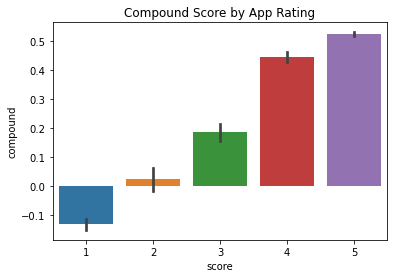

In [102]:
ax = sns.barplot(data=vaders, x='score', y='compound')
ax.set_title('Compound Score by App Rating')

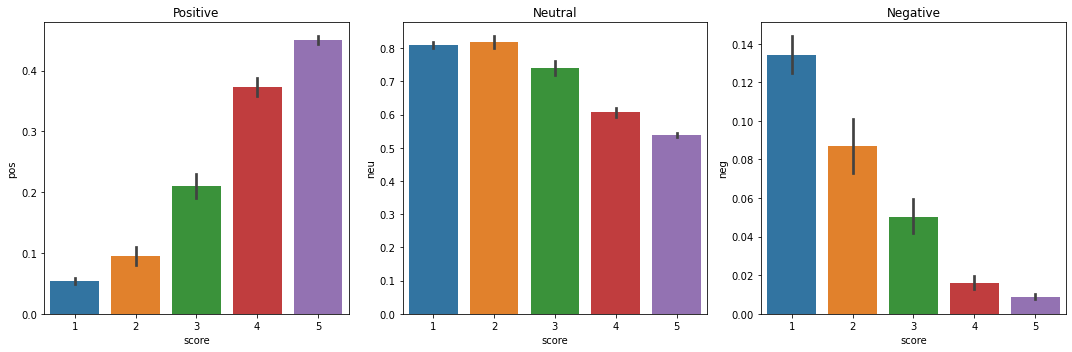

In [107]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))
sns.barplot(data=vaders, x='score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='score', y='neg', ax=axs[2])

axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Roberta Pretrained Model

In [110]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [111]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

C:\Users\User\anaconda3\lib\site-packages\huggingface_hub\file_download.py:129: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [112]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [116]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['content']
        myid = i
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/13227 [00:00<?, ?it/s]

Broke for id 3403


In [121]:
results_df = pd.DataFrame(res).T
results_df = pd.concat([results_df, vaders.drop(['pos', 'neg', 'neu', 'compound'], axis=1)], axis=1)
results_df

,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,index,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appName,sentiment
0,0.159,0.775,0.066,-0.5572,0.742227,0.212321,0.045452,0,d505016e-3b37-4ba2-97cf-16c9ef54f84c,David Webster,https://play-lh.googleusercontent.com/a-/ACB-R...,Found great bar jobs on here in the past but n...,1,0,3.2.11,2023-02-08 19:41:20,NaN,NaN,candidate,0
1,0.000,1.000,0.000,0.0000,0.300037,0.540562,0.159402,1,eae5efd4-26eb-469d-b793-f9689510ebbf,Joshua Espinoza,https://play-lh.googleusercontent.com/a/AGNmyx...,Try to upload resume and it just stays uploading!,2,0,3.2.6,2022-09-26 04:18:21,NaN,NaN,candidate,0
2,0.177,0.823,0.000,-0.6249,0.984752,0.012806,0.002442,2,c7156674-d0bf-497e-924e-07802e9cda9d,Robert Basom,https://play-lh.googleusercontent.com/a-/ACB-R...,"This is one of the worst apps I've ever used,w...",1,0,NaN,2022-07-20 08:11:02,NaN,NaN,candidate,0
3,0.134,0.866,0.000,-0.7546,0.959680,0.036837,0.003484,3,520a4e2f-d352-4fe4-a63b-ceea058663bf,Daniel DLS,https://play-lh.googleusercontent.com/a-/ACB-R...,If I cant upload a resume because for whatever...,1,1,3.2.5,2022-06-27 23:48:52,NaN,NaN,candidate,0
4,0.000,1.000,0.000,0.0000,0.563433,0.402357,0.034210,4,254d1260-7a30-4ae1-8c68-53f597c3c84c,Morris Kagunya,https://play-lh.googleusercontent.com/a-/ACB-R...,It's not logging in,1,0,3.2.3,2022-05-16 22:59:26,NaN,NaN,candidate,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13223,0.039,0.854,0.107,0.7650,0.042778,0.371820,0.585402,13232,6d98a697-0814-46f1-b8b8-fbbcb3f9f3b3,Tracy Nguyen,https://play-lh.googleusercontent.com/a-/ACB-R...,I am about to do it myself to make it happen a...,5,9,NaN,2021-11-13 03:00:17,NaN,NaN,mobile,1
13224,0.000,0.192,0.808,0.6369,0.012973,0.121171,0.865856,13233,8bbd9f45-73b4-42e0-8057-d4fc362c121a,Jeremy Yatchmenoff,https://play-lh.googleusercontent.com/a/AGNmyx...,The best,5,5,1.0.1.364,2021-11-03 15:02:20,NaN,NaN,mobile,1
13225,0.000,0.263,0.737,0.4215,0.012006,0.084710,0.903284,13234,6a62c0a3-c52d-4900-9fd4-32a10c277afe,David Shaw,https://play-lh.googleusercontent.com/a-/ACB-R...,Nice app,5,8,1.0.1.364,2021-10-22 06:44:09,NaN,NaN,mobile,1
13226,0.000,0.772,0.228,0.8122,0.001107,0.012334,0.986559,13235,46d05a26-97a1-4336-a274-521711f62960,Aaron Brodrik,https://play-lh.googleusercontent.com/a-/ACB-R...,Been using the website for awhile and it's the...,5,13,1.0.1.364,2021-09-16 23:34:32,NaN,NaN,mobile,1


In [122]:
results_df = results_df.drop([3403], axis=0)

In [123]:
results_df.columns

Index(['neg', 'neu', 'pos', 'compound', 'roberta_neg', 'roberta_neu',
       'roberta_pos', 'index', 'reviewId', 'userName', 'userImage', 'content',
       'score', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appName', 'sentiment'],
      dtype='object')

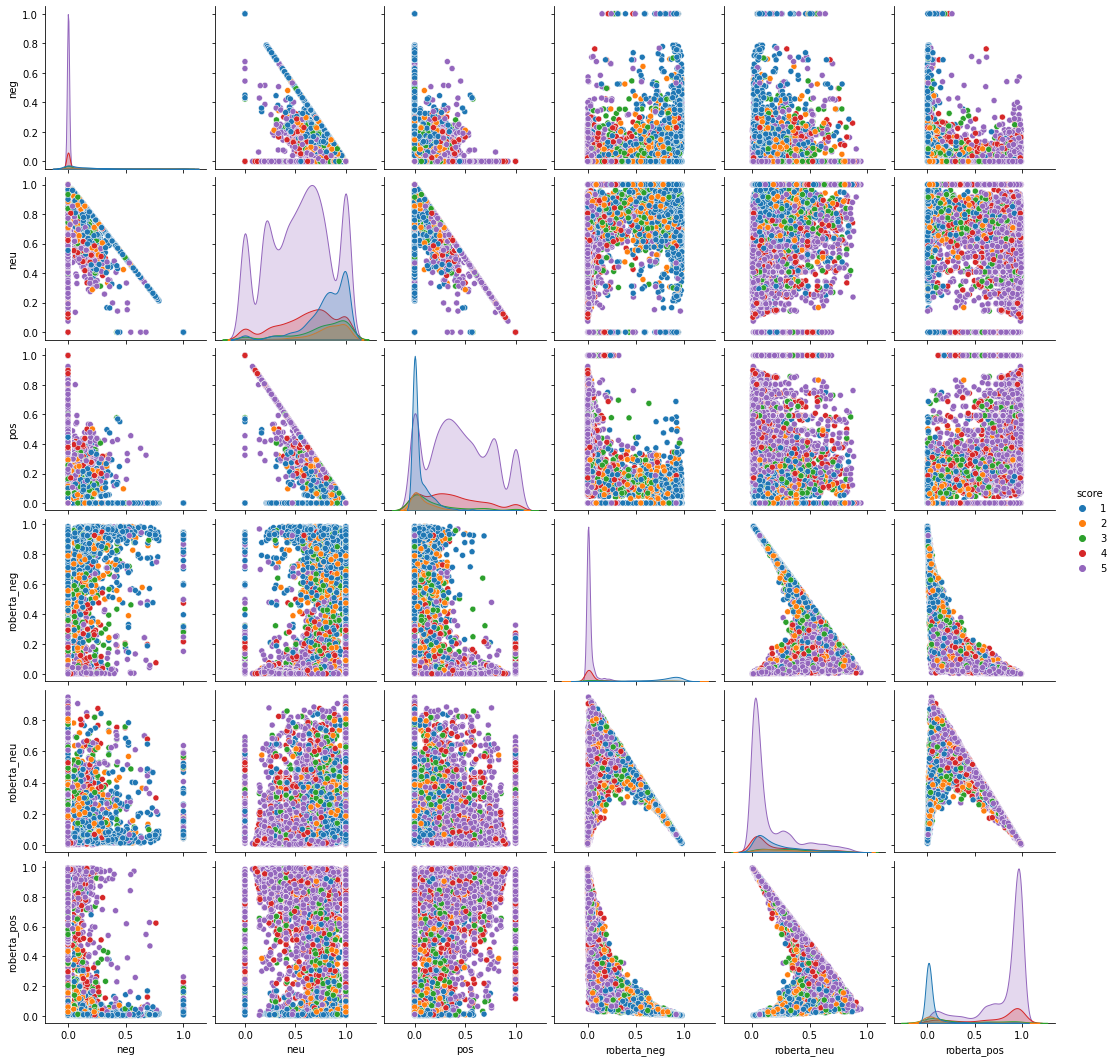

In [124]:
sns.pairplot(data=results_df, 
            vars=['neg', 'neu', 'pos', 
                 'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='score',
            palette='tab10')
plt.show()

In [126]:
df = df.drop(['at', 'replyContent', 'repliedAt'], axis=1)

In [127]:
df

,index,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,appName,sentiment
0,0,d505016e-3b37-4ba2-97cf-16c9ef54f84c,David Webster,https://play-lh.googleusercontent.com/a-/ACB-R...,Found great bar jobs on here in the past but n...,1,0,3.2.11,candidate,0
1,1,eae5efd4-26eb-469d-b793-f9689510ebbf,Joshua Espinoza,https://play-lh.googleusercontent.com/a/AGNmyx...,Try to upload resume and it just stays uploading!,2,0,3.2.6,candidate,0
2,2,c7156674-d0bf-497e-924e-07802e9cda9d,Robert Basom,https://play-lh.googleusercontent.com/a-/ACB-R...,"This is one of the worst apps I've ever used,w...",1,0,NaN,candidate,0
3,3,520a4e2f-d352-4fe4-a63b-ceea058663bf,Daniel DLS,https://play-lh.googleusercontent.com/a-/ACB-R...,If I cant upload a resume because for whatever...,1,1,3.2.5,candidate,0
4,4,254d1260-7a30-4ae1-8c68-53f597c3c84c,Morris Kagunya,https://play-lh.googleusercontent.com/a-/ACB-R...,It's not logging in,1,0,3.2.3,candidate,0
...,...,...,...,...,...,...,...,...,...,...
13222,13231,45d71edd-c573-4bc2-a219-ac7e31cb90ad,Alan J,https://play-lh.googleusercontent.com/a-/ACB-R...,Rather tasty,5,7,1.0.1.364,mobile,1
13223,13232,6d98a697-0814-46f1-b8b8-fbbcb3f9f3b3,Tracy Nguyen,https://play-lh.googleusercontent.com/a-/ACB-R...,I am about to do it myself to make it happen a...,5,9,NaN,mobile,1
13224,13233,8bbd9f45-73b4-42e0-8057-d4fc362c121a,Jeremy Yatchmenoff,https://play-lh.googleusercontent.com/a/AGNmyx...,The best,5,5,1.0.1.364,mobile,1
13225,13234,6a62c0a3-c52d-4900-9fd4-32a10c277afe,David Shaw,https://play-lh.googleusercontent.com/a-/ACB-R...,Nice app,5,8,1.0.1.364,mobile,1


# Preprocessing 
- Casing
- Noise Removal
- Tokenization
- Stopword Removal
- Text Normalization (Stemming and Lemmatization)

In [142]:
def preprocessing(text):
    stop_words = set(stopwords.words("english"))
    # lowering the case of all of the words
    text = text.lower()
    # removing urls
    text = re.sub(r"http\S+|www\S+|https\S+","",text, flags=re.MULTILINE)
    # removing punctuations
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # removing user @ references and '#' from tweet
    text = re.sub(r'\@\w+|\#', "", text)
    
    # removing stop words
    text_tokens = word_tokenize(text)
    filtered_words = [word for word in text_tokens if word not in stop_words]
    
    # Stemming
    ps = PorterStemmer()
    stemmed_words = [ps.stem(w) for w in filtered_words]
    
    # Lemmatizing
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in stemmed_words]
    
    return " ".join(lemma_words)

In [143]:
preprocessing(df.content[0])

'found great bar job past new updat plagu phish spam job list doesnt allow upload new resum sad see state app'

In [144]:
df.content[0]

"Found great bar jobs on here in the past but new updates a plagued with phishing spams job listings and doesn't allow to upload new resumes. Sad to see the state of this app"

In [145]:
df['content'] = df['content'].apply(preprocessing)

# Vectorizing Tokens

In [155]:
def get_feature_vector(train_fit):
    vector = TfidfVectorizer(sublinear_tf=True)
    vector.fit(train_fit)
    return vector

In [146]:
X = df.content
y = df.sentiment

In [154]:
corpus = []
corpus = df.content.copy()
corpus

0        found great bar job past new updat plagu phish...
1                             tri upload resum stay upload
2        one bad app ive ever usedwil never appli job u...
3        cant upload resum whatev reason stay stuck loa...
4                                                      log
                               ...                        
13222                                         rather tasti
13223    make happen sake cours work togeth make sure m...
13224                                                 best
13225                                             nice app
13226    use websit awhil best place find hospit job ar...
Name: content, Length: 13227, dtype: object

In [159]:
demo_embedded_matrix = get_feature_vector(corpus)
print(demo_embedded_matrix)

TfidfVectorizer(sublinear_tf=True)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)